# Import Lib
Neural machine translation with a Transformer and Keras - https://www.tensorflow.org/text/tutorials/transformer#the_transformer

In [1]:
#!pip install tensorflow_text

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15,8]
import seaborn as sns
import plotly.graph_objects as go

In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Layer, MultiHeadAttention, LayerNormalization, Conv1D
from tensorflow.keras.layers import Add, Dense, Dropout, Flatten, Concatenate, BatchNormalization, MaxPooling1D
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.math import rsqrt, minimum
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, Callback
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.ops import round as tf_round
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.backend import set_value
from tensorflow.signal import stft, hann_window

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error

In [5]:
from tensorflow.keras import initializers

initializer_for_relu = initializers.HeNormal() # For layers with activation function Relu
initializer_for_sigmoid = initializers.GlorotNormal() # For layers with activation function Sigmoid

In [6]:
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

## Import Data

In [7]:
# Mount google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = '/content/drive/MyDrive/MyColabProject/Data'
data_df = pd.read_csv(path+'/raw_nsepy_inp512_differencedVal_fourierTransform.csv')
data_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,-4.45,6.45,-3.1,3.00,3.10,-2.55,-3.25,9.45,1.55,-5.2,...,-3.25,5.70,-5.45,3.20,-4.45,-2.15,-1.05,-1.10,3.05,4.35
1,6.45,-3.10,3.0,3.10,-2.55,-3.25,9.45,1.55,-5.20,-4.0,...,5.70,-5.45,3.20,-4.45,-2.15,-1.05,-1.10,3.05,4.35,2.05
2,-3.10,3.00,3.1,-2.55,-3.25,9.45,1.55,-5.20,-4.00,1.5,...,-5.45,3.20,-4.45,-2.15,-1.05,-1.10,3.05,4.35,2.05,1.70


In [9]:
data_df.shape

(41412, 513)

## Train Test Split
* Length of the input 39 <br>
* Length of Output and Context 1 <br>

In [157]:
data_df.iloc[:2400,256:].shape

(2400, 257)

In [158]:
data_df.iloc[:2400,256:].head(3)

,256,257,258,259,260,261,262,263,264,265,...,503,504,505,506,507,508,509,510,511,512
0,2.75,-0.40,-1.65,-0.85,-1.0,0.30,3.90,7.85,2.75,4.30,...,-3.25,5.70,-5.45,3.20,-4.45,-2.15,-1.05,-1.10,3.05,4.35
1,-0.40,-1.65,-0.85,-1.00,0.3,3.90,7.85,2.75,4.30,-5.35,...,5.70,-5.45,3.20,-4.45,-2.15,-1.05,-1.10,3.05,4.35,2.05
2,-1.65,-0.85,-1.00,0.30,3.9,7.85,2.75,4.30,-5.35,-0.25,...,-5.45,3.20,-4.45,-2.15,-1.05,-1.10,3.05,4.35,2.05,1.70


In [159]:
data_q1 = data_df.iloc[:16800,:129].copy()
data_q2 = data_df.iloc[:16800,128:257].copy()
data_q3 = data_df.iloc[:16800,256:385].copy()
data_q4 = data_df.iloc[:16800,384:].copy()

data_df_merged = pd.DataFrame()
data_df_merged = pd.concat([pd.DataFrame(data_q1.values),pd.DataFrame(data_q2.values),pd.DataFrame(data_q3.values),pd.DataFrame(data_q4.values)],
                           ignore_index=True)
print(data_df_merged.shape)
data_df_merged.head(3)

(67200, 129)


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,-4.45,6.45,-3.1,3.00,3.10,-2.55,-3.25,9.45,1.55,-5.2,...,-7.65,-1.25,0.00,8.00,-6.05,1.80,-0.75,-0.9,-0.1,-2.8
1,6.45,-3.10,3.0,3.10,-2.55,-3.25,9.45,1.55,-5.20,-4.0,...,-1.25,0.00,8.00,-6.05,1.80,-0.75,-0.90,-0.1,-2.8,-1.5
2,-3.10,3.00,3.1,-2.55,-3.25,9.45,1.55,-5.20,-4.00,1.5,...,0.00,8.00,-6.05,1.80,-0.75,-0.90,-0.10,-2.8,-1.5,0.5


In [160]:
#data_128.head(3)

In [161]:
data_df_merged.tail(3)

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
67197,3.95,6.35,-10.60,1.55,3.40,6.05,4.20,-0.95,0.40,1.85,...,15.65,-3.50,-9.95,-6.55,-0.15,-1.2,-8.8,0.6,5.4,-7.00
67198,6.35,-10.60,1.55,3.40,6.05,4.20,-0.95,0.40,1.85,6.20,...,-3.50,-9.95,-6.55,-0.15,-1.20,-8.8,0.6,5.4,-7.0,25.00
67199,-10.60,1.55,3.40,6.05,4.20,-0.95,0.40,1.85,6.20,6.80,...,-9.95,-6.55,-0.15,-1.20,-8.80,0.6,5.4,-7.0,25.0,-12.65


In [162]:
inp_len = 128 # Length of the input
out_len = 1 # Length of Output and Context

In [163]:
prediction_percentage = 0.1 #0.025
train_df, test_df = train_test_split(data_df_merged, test_size=prediction_percentage, random_state=1, shuffle=True)

In [164]:
print('Train shape',train_df.shape)
print('Test shape',test_df.shape)

Train shape (60480, 129)
Test shape (6720, 129)


In [165]:
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=1, shuffle=True)

In [166]:
print('Train shape',train_df.shape)
print('Validation shape',val_df.shape)
print('Test shape',test_df.shape)

Train shape (45360, 129)
Validation shape (15120, 129)
Test shape (6720, 129)


Keras Model.fit training expects (inputs, labels) pairs. The inputs is tokenized sequences. The labels are the same sequences shifted by 1. This shift is so that at each location input sequence, the label in the next token.

In [167]:
X_train = train_df.drop(columns=train_df.columns[inp_len:].values).values
y_train = train_df.drop(columns=train_df.columns[:inp_len].values).values

X_val = val_df.drop(columns=val_df.columns[inp_len:].values).values
y_val = val_df.drop(columns=val_df.columns[:inp_len].values).values

X_test = test_df.drop(columns=test_df.columns[inp_len:].values).values
y_test = test_df.drop(columns=test_df.columns[:inp_len].values).values


In [168]:
print('X Train shape',X_train.shape)
print('Y Train shape',y_train.shape)

print('X Validation shape',X_val.shape)
print('Y Validation shape',y_val.shape)

print('X Test shape',X_test.shape)
print('Y Test shape',y_test.shape)

X Train shape (45360, 128)
Y Train shape (45360, 1)
X Validation shape (15120, 128)
Y Validation shape (15120, 1)
X Test shape (6720, 128)
Y Test shape (6720, 1)


In [169]:
X_train_f = X_train.astype(np.float32)
y_train_t = tf.convert_to_tensor(y_train)

X_val_f = X_val.astype(np.float32)
y_val_t = tf.convert_to_tensor(y_val)

X_test_f = X_test.astype(np.float32)
y_test_t = tf.convert_to_tensor(y_test)

In [170]:
X_train_f[0]

array([-23.7 ,   7.65,  -4.25,  -1.4 ,   7.15,  -5.5 ,  14.  ,   0.  ,
        -4.9 ,   4.  ,  10.55, -11.  ,  -8.25,  -7.3 , -15.05,  -3.5 ,
        14.  ,  -1.2 , -12.35, -12.95,  -3.  ,  -5.7 ,   5.75,   2.8 ,
       -15.2 ,   1.3 ,  12.35,   8.8 ,  -1.95,   4.8 ,  -5.4 ,  -8.3 ,
        14.7 ,  -6.5 ,  -0.45,  11.  ,  13.45,  12.5 , -12.4 ,   3.55,
        13.05,  22.3 ,  10.85,   6.65,   6.9 ,  -8.5 ,  -1.75,  -8.65,
         3.2 ,  -7.65,  10.75,  -0.8 ,   6.75,  22.55,  -6.3 ,  -5.5 ,
       -11.  , -18.35, -14.55,  -9.5 ,  -6.8 ,   6.5 ,  20.8 ,   7.95,
        19.8 ,  42.15,  -1.55,   0.9 ,  -1.65,   2.3 ,   3.35,  -5.35,
        -5.35, -12.45,  -3.15,   8.05,  -5.8 ,  -4.9 , -16.9 , -14.9 ,
        13.45, -23.05,   2.05,   3.95,  -5.3 ,   1.3 ,  -7.65,  -0.25,
        17.1 ,  33.8 ,   6.6 ,   2.45,  20.9 ,  -8.6 ,  -0.9 ,  11.75,
        19.1 ,  -8.8 ,  -6.7 , -10.3 ,  10.8 ,   3.  ,   1.8 ,   7.3 ,
         2.4 ,  -6.7 ,  -1.5 ,  21.55,   0.85,   1.85,  -7.55,  -0.7 ,
      

In [171]:
y_train[0]

array([6.55])

In [172]:
y_train_t[0]

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([6.55])>

## Testing tf.signal.stft

In [ ]:
spectrogram1 = tf.signal.stft(signals=X_train_f[0],
                              frame_length=512,
                              frame_step=1)

print(X_train[0].shape[0])
print(spectrogram1.shape)
print(spectrogram1)

In [ ]:
spectrogram2 = tf.signal.stft(X_train_f[0], frame_length=512, frame_step=256)

print(X_train[0].shape[0])
print(spectrogram2.shape)
print(spectrogram2)

In [ ]:
spectrogram3 = tf.signal.stft(X_train_f[0], frame_length=256, frame_step=128)

print(X_train[0].shape[0])
print(spectrogram3.shape)
print(spectrogram3)

In [ ]:
spectrogram4 = tf.signal.stft(X_train_f[0], frame_length=16, frame_step=8)

print(X_train[0].shape[0])
print(spectrogram4.shape)
print(spectrogram4)

# Model Architecture <br>
* The querys is what you're trying to find.
* The keys what sort of information the dictionary has.
* The value is that information.


<b>fft_length and frame_length</b>
* The number of frequency bins depends on the FFT size (fft_length), which is often set to the next power of 2 that is greater than or equal to frame_length
* example, if frame_lenght = 39, Next power of 2 greater than 39 is 64. Setting fft_length = 64 would allow the FFT algorithm to work more efficiently by padding the input to a length of 64.
* or choose frame_lenght any of 2, 4, 8, 16, 32, 64, ... <br>

<b>frame_step</b>
* To choose frame_step, 50% Overlap (a common choice): To achieve 50% overlap, set frame_step to half the frame_length: frame_step = frame_length/2
* example, if frame_length=8, then frame_step=8/2 = 4. This will give you overlapping frames, which improves frequency resolution.<br>

<b>Frequency_bins v/s time_bins</b>
*  have more Frequency_bins if identifying a long-term uptrend or downtrend based on weekly or monthly stock price data, or detecting cyclic behavior like seasonality.
* have more time_bins if Detecting intraday trends or anomalies (like a sudden price surge due to a news release).

In [173]:
# Hyperparameters for Fourier Transform
sample_signal_length = [128, 64, 32, 16] # Length of the input time series
sample_frame_length = [64, 32, 16, 8] # window size for Fourier Transform
sample_frame_size = len(sample_frame_length)
sample_frame_step = [32, 16, 8, 4] # Hop size for Fourier Transform
sample_fft_length = sample_frame_length
MAX_INPUT_SIZE = 128

# Hyperparameters for Attention Layer and DNN Layer
sample_num_layers = [1, 2, 4, 8] # number of TransformerEncoderLayer layers (Original paper = 6)
sample_num_heads = [1, 1, 1, 1] # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
sample_dropout_rate = 0.2 # Dropout rate
sample_regularizer_rate = 0.005 # Use to regularizer the weights in attention model

# Extra Parameters
sample_index_for_testing = 0

In [174]:
int(tf.math.floor((sample_fft_length[sample_index_for_testing]/2) +1))

33

In [175]:
sample_fft_length[sample_index_for_testing]

64

In [176]:
# The STFT output shape can be defined as:
# Output Shape = (batch_size, 𝐹, 𝑇)
sample_time_bins = list()
sample_frequency_bins = list()
for i in np.arange(sample_frame_size):
  print(i)
  # Number of Time Frames (T)
  sample_time_bins.append(int(((sample_signal_length[i] - sample_fft_length[i])/sample_frame_step[i] )+1 ))
  print('Time Bins =',sample_time_bins[i])

  # Number of Frequency Bins (F)
  sample_frequency_bins.append(int(tf.math.floor((sample_fft_length[i]/2) +1)))
  print('Frequency Bins =',sample_frequency_bins[i])

  print('output_shape=[batch_size, time_bins, frequency_bins]')
  print('Output shape = (batch_size,',sample_time_bins[i],',',sample_frequency_bins[i],')\n')

0
Time Bins = 3
Frequency Bins = 33
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 3 , 33 )

1
Time Bins = 3
Frequency Bins = 17
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 3 , 17 )

2
Time Bins = 3
Frequency Bins = 9
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 3 , 9 )

3
Time Bins = 3
Frequency Bins = 5
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 3 , 5 )



In [177]:
tf.math.sqrt(tf.cast(65, dtype=tf.bfloat16))*3

<tf.Tensor: shape=(), dtype=bfloat16, numpy=24.25>

In [178]:
tf.math.sqrt(tf.cast(33, dtype=tf.bfloat16))*3

<tf.Tensor: shape=(), dtype=bfloat16, numpy=17.25>

In [179]:
tf.math.sqrt(tf.cast(17, dtype=tf.bfloat16))*3

<tf.Tensor: shape=(), dtype=bfloat16, numpy=12.375>

In [180]:
tf.math.sqrt(tf.cast(9, dtype=tf.bfloat16))*3

<tf.Tensor: shape=(), dtype=bfloat16, numpy=9>

In [181]:
tf.math.sqrt(tf.cast(5, dtype=tf.bfloat16))*3

<tf.Tensor: shape=(), dtype=bfloat16, numpy=6.6875>

In [182]:
data_512_vals = data_df.iloc[:,:-1].values
data_512_vals

array([[ -4.45,   6.45,  -3.1 , ...,  -1.05,  -1.1 ,   3.05],
       [  6.45,  -3.1 ,   3.  , ...,  -1.1 ,   3.05,   4.35],
       [ -3.1 ,   3.  ,   3.1 , ...,   3.05,   4.35,   2.05],
       ...,
       [  4.4 ,   6.  ,  -6.1 , ..., -14.1 ,  -9.4 , -37.6 ],
       [  6.  ,  -6.1 ,  -2.55, ...,  -9.4 , -37.6 ,   4.75],
       [ -6.1 ,  -2.55, -15.25, ..., -37.6 ,   4.75,  -5.25]])

In [183]:
data_512_vals[:,-sample_frame_length[sample_index_for_testing]:].shape

(41412, 64)

In [184]:
data_512_vals[:,-sample_frame_length[sample_index_for_testing]:]

array([[  1.1 ,   6.8 ,   2.5 , ...,  -1.05,  -1.1 ,   3.05],
       [  6.8 ,   2.5 ,  -2.9 , ...,  -1.1 ,   3.05,   4.35],
       [  2.5 ,  -2.9 ,   4.5 , ...,   3.05,   4.35,   2.05],
       ...,
       [ -5.25,  25.25,  -9.6 , ..., -14.1 ,  -9.4 , -37.6 ],
       [ 25.25,  -9.6 ,  10.  , ...,  -9.4 , -37.6 ,   4.75],
       [ -9.6 ,  10.  ,  11.25, ..., -37.6 ,   4.75,  -5.25]])

In [185]:
data_512_vals[:,-sample_frame_length[1]:].shape

(41412, 32)

In [186]:
data_512_vals[:,-sample_frame_length[1]:]

array([[  1.15,  -4.15,  -1.7 , ...,  -1.05,  -1.1 ,   3.05],
       [ -4.15,  -1.7 ,   3.15, ...,  -1.1 ,   3.05,   4.35],
       [ -1.7 ,   3.15,   0.75, ...,   3.05,   4.35,   2.05],
       ...,
       [ -3.  ,  -0.15, -14.85, ..., -14.1 ,  -9.4 , -37.6 ],
       [ -0.15, -14.85,  13.35, ...,  -9.4 , -37.6 ,   4.75],
       [-14.85,  13.35,   9.05, ..., -37.6 ,   4.75,  -5.25]])

## The Fourier Transform layer

The output is a 2D array of shape (n_freqs, n_times), where n_freqs is the number of frequency bins (same as the length of f), and n_times is the number of time segments (same as the length of t).
* Rows of Zxx correspond to different frequencies (i.e., values in the f array).
* Columns of Zxx correspond to different time segments (i.e., values in the t array).
* The magnitude of the complex numbers in Zxx (np.abs(Zxx)) represents the strength or amplitude of each frequency component at that time segment.
* The phase of the complex numbers in Zxx (np.angle(Zxx)) represents the phase information of the signal at that frequency and time.
*  A larger window (windows_size, hops) gives better frequency resolution but poorer time resolution. You may need to experiment with different values based on your data.

* tf.py_function allows TensorFlow to execute scipy_stft_fn, passing a tensor as input, converting it to a NumPy array internally, and returning a tensor that is compatible with TensorFlow.
* In the build method of the FourierTransform class, the shape of self.kernel should be a tuple, but it is set as a single value (self.windows_size). self.windows_size should be wrapped in parentheses to specify the shape correctly, assuming it's a 1D kernel.

In [187]:
class FourierTransform(Layer):
  def __init__(self, signal_length, frame_length, frame_step):
    super(FourierTransform, self).__init__()
    self.signal_length = signal_length
    self.frame_length = frame_length
    self.frame_step = frame_step

  def build(self, input_shape):
    # Define weights
    self.kernel = self.add_weight(
        shape=(self.signal_length,), # the use of ',' after self.signal_len is a must, read the above mentioned comments point-2
        initializer=initializer_for_relu,
        trainable=False
    )

  def call(self, x):
    #window_gen = hann_window(self.windows_size)  # symmetric Gaussian window
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(signals=x, frame_length=self.frame_length, fft_length=self.frame_length, frame_step=self.frame_step)
    magnitude_x = tf.math.abs(spectrogram)
    #angle_x = tf.math.angle(spectrogram) # Disable it if using only magnitude as output
    magnitude_x = tf_round(magnitude_x, 4)
    #angle_x = tf_round(angle_x, 4) # Disable it if using only magnitude as output
    return magnitude_x #, angle_x

In [188]:
# Create an Embedding Object
sft_layer = FourierTransform(signal_length=sample_signal_length[sample_index_for_testing],
                             frame_length=sample_frame_length[sample_index_for_testing],
                             frame_step=sample_frame_step[sample_index_for_testing])
sft_layer.build(X_train_f[:3].shape)
# Calling the function
out_sft_mag = sft_layer(X_train_f[:3])

In [189]:
print(out_sft_mag.shape)

(3, 3, 33)


In [190]:
X_train_f[0,:]

array([-23.7 ,   7.65,  -4.25,  -1.4 ,   7.15,  -5.5 ,  14.  ,   0.  ,
        -4.9 ,   4.  ,  10.55, -11.  ,  -8.25,  -7.3 , -15.05,  -3.5 ,
        14.  ,  -1.2 , -12.35, -12.95,  -3.  ,  -5.7 ,   5.75,   2.8 ,
       -15.2 ,   1.3 ,  12.35,   8.8 ,  -1.95,   4.8 ,  -5.4 ,  -8.3 ,
        14.7 ,  -6.5 ,  -0.45,  11.  ,  13.45,  12.5 , -12.4 ,   3.55,
        13.05,  22.3 ,  10.85,   6.65,   6.9 ,  -8.5 ,  -1.75,  -8.65,
         3.2 ,  -7.65,  10.75,  -0.8 ,   6.75,  22.55,  -6.3 ,  -5.5 ,
       -11.  , -18.35, -14.55,  -9.5 ,  -6.8 ,   6.5 ,  20.8 ,   7.95,
        19.8 ,  42.15,  -1.55,   0.9 ,  -1.65,   2.3 ,   3.35,  -5.35,
        -5.35, -12.45,  -3.15,   8.05,  -5.8 ,  -4.9 , -16.9 , -14.9 ,
        13.45, -23.05,   2.05,   3.95,  -5.3 ,   1.3 ,  -7.65,  -0.25,
        17.1 ,  33.8 ,   6.6 ,   2.45,  20.9 ,  -8.6 ,  -0.9 ,  11.75,
        19.1 ,  -8.8 ,  -6.7 , -10.3 ,  10.8 ,   3.  ,   1.8 ,   7.3 ,
         2.4 ,  -6.7 ,  -1.5 ,  21.55,   0.85,   1.85,  -7.55,  -0.7 ,
      

In [191]:
# Inspecting the time-component when frequency-component = 3
#out_sft_mag[0,1,:]

In [192]:
# Inspecting the time-component when frequency-component = 12
out_sft_mag[0,0,:]

<tf.Tensor: shape=(33,), dtype=float32, numpy=
array([49.4747, 83.5963, 66.6763, 14.8444, 46.8029, 53.6205, 18.4438,
       57.4503, 51.7176, 44.1617, 66.5546, 15.8487, 65.2762, 81.3699,
       61.9883, 41.281 , 37.9105, 31.2639, 40.9767, 65.2593, 46.6781,
       57.9221, 32.4775, 22.6825, 32.5748, 27.166 , 29.6963, 61.7936,
       59.9696, 25.9391, 16.6114,  6.4021, 11.3613], dtype=float32)>

In [193]:
# Inspecting the frequency-component when time-component = 3
out_sft_mag[0,:,1]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([83.5963, 38.0827, 80.5944], dtype=float32)>

In [194]:
# Inspecting the frequency-component when time-component = 12
out_sft_mag[0,:,4]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 46.8029, 112.8171,  72.9829], dtype=float32)>

## Custom Attention Block

In [195]:
class BaseAttention(Layer):
  def __init__(self, frequency_bins, time_bins, **kwargs):
    super().__init__()
    self.mha = MultiHeadAttention(key_dim = frequency_bins,
                                  kernel_initializer = initializer_for_relu,
                                  **kwargs)
    self.layernorm = LayerNormalization()
    self.add = Add()
    self.frequency_bins = frequency_bins
    self.time_bins = time_bins

  def build(self, input_shape):
    # Define weights
    self.kernel = self.add_weight(
        shape=(self.time_bins, self.frequency_bins),
        initializer=initializer_for_relu,
        trainable=True
    )

## self-attention layer - Magnitude and Angle

* tf.ensure_shape Updates the shape of a tensor and checks at runtime that the shape holds.
* When executed, this operation asserts that the input tensor x's shape is compatible with the shape argument.

In [196]:
class SelfAttention(BaseAttention):
  def __init__(self, frequency_bins, time_bins, **kwargs):
      # Call the parent class (BaseAttention) constructor
      super().__init__(frequency_bins, time_bins, **kwargs)

  def call(self, magnitude):
    magnitude = tf.ensure_shape(magnitude, [None, self.time_bins, self.frequency_bins])
    attn_output = self.mha(
        query=magnitude,  # The querys is what you're trying to find.
        key=magnitude,  # The keys what sort of information the dictionary has.
        value=magnitude # The value is that information.
        )
    # Cache the attention scores for plotting later.
    #self.last_attn_scores = attn_scores

    x = self.add([magnitude, attn_output])
    x = self.layernorm(x)
    x = tf_round(x, 4)
    return x

In [197]:
sample_lsa = SelfAttention(frequency_bins=sample_frequency_bins[sample_index_for_testing],
                           time_bins=sample_time_bins[sample_index_for_testing],
                           num_heads=sample_num_heads[sample_index_for_testing],
                           dropout=sample_dropout_rate,
                           kernel_regularizer=l2(sample_regularizer_rate),
                           bias_regularizer=l2(sample_regularizer_rate),
                           activity_regularizer=l2(sample_regularizer_rate)
                                    )

In [198]:
#sample_lsa.build(out_sft_mag.shape)
out_lsa_mag = sample_lsa(out_sft_mag)
print(out_sft_mag.shape)
print(out_lsa_mag.shape)

(3, 3, 33)
(3, 3, 33)


In [199]:
out_lsa_mag[0,0,:]

<tf.Tensor: shape=(33,), dtype=float32, numpy=
array([-0.6379,  0.4892,  1.4973, -0.6584, -1.544 , -0.0742, -0.3112,
       -0.228 ,  0.4559, -1.689 ,  1.5884,  0.5094, -0.7532, -0.8875,
       -0.442 , -0.578 , -1.2596,  0.1763,  2.2228, -1.1544, -0.0423,
        0.642 ,  1.7316, -1.2732, -0.1241,  0.112 , -0.0275,  2.3853,
       -0.1185,  0.7194, -0.4214, -0.2357, -0.0694], dtype=float32)>

## Feed Forward Network Layer

In [200]:
class FeedForward(Layer):
  # dff - dence feed forward neurons
  # sft_len - output shape Fourier Transform
  def __init__(self, frequency_bins, time_bins, dropout_rate=0.1):
    super().__init__()
    self.seq = Sequential([
        #BatchNormalization(),
        #Dense(tf.get_static_value(tf.cast(tf.math.sqrt(tf.cast(frequency_bins, dtype=tf.bfloat16))*time_bins, dtype=tf.int32)),
        #      activation='relu', kernel_initializer=initializer_for_relu),
        #Dropout(dropout_rate),

        #BatchNormalization(),
        Dense(tf.get_static_value(tf.cast(frequency_bins*time_bins, dtype=tf.int32)),
              activation='relu', kernel_initializer=initializer_for_relu),
        Dropout(dropout_rate),

        #BatchNormalization(),
        Dense(frequency_bins, activation='relu', kernel_initializer=initializer_for_relu),
        Dropout(dropout_rate)
    ])
    self.add = Add()
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [201]:
sample_ffn = FeedForward(frequency_bins=sample_frequency_bins[sample_index_for_testing],
                         time_bins=sample_time_bins[sample_index_for_testing])
sample_ffn_out = sample_ffn(out_lsa_mag)
print(out_lsa_mag.shape)
print(sample_ffn_out.shape)

(3, 3, 33)
(3, 3, 33)


In [202]:
sample_ffn_out[0,0,:]

<tf.Tensor: shape=(33,), dtype=float32, numpy=
array([-0.99479145,  0.70353824,  1.6665969 , -1.0153971 , -1.4800491 ,
        1.0646152 ,  0.30123562, -0.5827806 ,  0.6252573 , -1.7221329 ,
        1.2429731 ,  0.15841669, -1.0656124 ,  0.12197745, -0.7297208 ,
       -0.49421567, -0.9288469 ,  0.15048313,  2.0490687 , -1.5139513 ,
       -0.28217673,  0.29169953,  1.7265692 , -1.0709531 ,  0.7760386 ,
       -0.22759789, -0.13404097,  2.0439768 , -0.44225088,  0.36949807,
        0.00363183, -0.1876933 , -0.4233639 ], dtype=float32)>

## Complete Encoder Layer

In [203]:
class EncoderLayer(Layer):
  def __init__(self,*, frequency_bins, time_bins, num_heads, dropout_rate, regularizer_rate):
    super().__init__()

    self.self_attention = SelfAttention(frequency_bins=frequency_bins,
                                        time_bins=time_bins,
                                        num_heads=num_heads,
                                        dropout=dropout_rate,
                                        kernel_regularizer=l2(regularizer_rate),
                                        bias_regularizer=l2(regularizer_rate),
                                        activity_regularizer=l2(regularizer_rate)
                                             )

    self.ffn = FeedForward(frequency_bins=frequency_bins, time_bins=time_bins, dropout_rate=dropout_rate)

  def call(self, angle):
    angle = self.self_attention(angle)
    angle = self.ffn(angle)
    return angle

In [204]:
sample_encoder_layer = EncoderLayer(frequency_bins=sample_frequency_bins[sample_index_for_testing],
                                    time_bins=sample_time_bins[sample_index_for_testing],
                                    num_heads=sample_num_heads[sample_index_for_testing],
                                    dropout_rate=sample_dropout_rate,
                                    regularizer_rate=sample_regularizer_rate)
#sample_encoder_layer.build(out_sft_ang.shape)

In [205]:
sample_encoder_output = sample_encoder_layer(out_sft_mag, training=False)
# Print the shape.
print(out_sft_mag.shape)
print(sample_encoder_output.shape)

(3, 3, 33)
(3, 3, 33)


In [206]:
class Encoder(Layer):
  def __init__(self, *, frequency_bins, time_bins, num_layers, num_heads, dropout_rate, regularizer_rate):
    super().__init__()

    self.num_layers=num_layers

    self.enc_layers = [ EncoderLayer(frequency_bins=frequency_bins,
                                     time_bins=time_bins,
                                     num_heads=num_heads,
                                     dropout_rate=dropout_rate,
                                     regularizer_rate=regularizer_rate
                                     ) for _ in range(num_layers)]

  def call(self, angle):
    for i in range(self.num_layers):
      angle = self.enc_layers[i](angle)

    #self.last_attn_scores = self.enc_layers[-1].last_attn_scores
    return angle

In [207]:
# Testing the encoder

# Instantiate the encoder.
sample_encoder = Encoder(frequency_bins=sample_frequency_bins[sample_index_for_testing],
                         time_bins=sample_time_bins[sample_index_for_testing],
                         num_layers=sample_num_layers[sample_index_for_testing],
                         num_heads=sample_num_heads[sample_index_for_testing],
                         dropout_rate=sample_dropout_rate,
                         regularizer_rate=sample_regularizer_rate)
#sample_encoder.build(out_sft_ang.shape)

In [208]:
sample_encoder_output = sample_encoder(out_sft_mag, training=False)
# Print the shape.
print(out_sft_mag.shape)
print(sample_encoder_output.shape)

(3, 3, 33)
(3, 3, 33)


In [209]:
sample_encoder_output[0,0,:]

<tf.Tensor: shape=(33,), dtype=float32, numpy=
array([-1.4658171 , -0.8076931 , -0.9562509 , -0.24354586,  1.2581348 ,
        0.70159423, -0.2491329 ,  0.62079704, -1.49497   , -0.09804383,
       -0.99722254, -0.1836161 , -0.5307962 ,  0.56722844,  0.9252665 ,
       -0.4984006 , -0.32068992,  1.7840211 , -1.3501369 , -0.287884  ,
        2.2036347 ,  1.4136574 ,  0.5852592 , -0.8716576 ,  1.3097744 ,
       -1.7632909 ,  0.4046941 , -0.44546703,  0.24252614,  0.2748306 ,
        0.44161543, -1.3143466 ,  1.1459292 ], dtype=float32)>

## Transformer

In [210]:
class TransformerLayer(Layer):
  def __init__(self, *, signal_length, max_signal_length, frame_length, frame_step,
               #frequency_bins, time_bins,
               num_heads, num_layers, dropout_rate=0.1, regularizer_rate):
    super().__init__()

    self.time_bins = tf.cast(((signal_length - frame_length)/frame_step)+1 , dtype=tf.int32)

    self.frequency_bins = tf.cast(tf.math.floor((frame_length/2) +1), dtype=tf.int32)

    self.sft_layer = FourierTransform(signal_length=signal_length,
                                      frame_length=frame_length,
                                      frame_step=frame_step)

    self.encoder = Encoder(frequency_bins=tf.get_static_value(self.frequency_bins),
                           time_bins=tf.get_static_value(self.time_bins),
                           num_layers=num_layers,
                           num_heads=num_heads,
                           dropout_rate=dropout_rate,
                           regularizer_rate=regularizer_rate)

    self.flatten_layer = Flatten()

    self.conv_layer = Conv1D(filters=tf.get_static_value(tf.cast(max_signal_length, dtype=tf.int32)),
                             kernel_size=[tf.get_static_value(self.time_bins)], activation='relu', kernel_initializer=initializer_for_relu,
                             input_shape = (tf.get_static_value(self.time_bins),tf.get_static_value( self.frequency_bins)))

    #self.seq = Sequential([
    #        Dense(tf.get_static_value(tf.cast(tf.math.sqrt(tf.cast(signal_len, dtype=tf.bfloat16)), dtype=tf.int32)),
    #              activation='relu', kernel_initializer=initializer_for_relu),
    #        Dropout(dropout_rate)

            #BatchNormalization(),
            #Dense(tf.get_static_value(tf.cast((frequency_bins*time_bins)/2, dtype=tf.int32)),
            #      activation='relu', kernel_initializer=initializer_for_relu),
            #Dropout(dropout_rate),

            #BatchNormalization(),
            #Dense(frequency_bins, activation='relu', kernel_initializer=initializer_for_relu),
            #Dropout(dropout_rate)
     #   ])

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    magnitude_x = self.sft_layer(inputs)

    #self.encoder.build(angle_x.shape)
    enc_out = self.encoder(magnitude_x)  # (batch_size, frequency_bins, time_bins)

    # Final linear layer output.
    #dec_out = self.flatten_layer(dec_out) # (batch_size, frequency_bins * time_bins)

    # Reduce the dimentionality.
    enc_out = self.conv_layer(enc_out)

    # Final linear layer output.
    enc_out = self.flatten_layer(enc_out) # (batch_size, frequency_bins * time_bins)

    # Return the output and the attention weights.
    return enc_out

In [211]:
sample_transformer_layer = TransformerLayer(signal_length=sample_signal_length[sample_index_for_testing],
                                            max_signal_length = MAX_INPUT_SIZE,
                                            frame_length=sample_frame_length[sample_index_for_testing],
                                            frame_step=sample_frame_step[sample_index_for_testing],
                                            num_layers=sample_num_layers[sample_index_for_testing],
                                            num_heads=sample_num_heads[sample_index_for_testing],
                                            dropout_rate=sample_dropout_rate,
                                            regularizer_rate=sample_regularizer_rate)

sample_transformer_layer_output = sample_transformer_layer(X_train_f[:3])

In [212]:
sample_transformer_layer_output.shape

TensorShape([3, 128])

## Regression - Feed Forward Network Layer

In [213]:
'''
class RegressionFeedForward(Layer):
  # sft_len - output shape Fourier Transform
  def __init__(self, signal_len, dropout_rate=0.1):
    super().__init__()
    self.seq = Sequential([

      BatchNormalization(),
      Dense(tf.get_static_value(tf.cast(tf.math.sqrt(tf.cast(signal_len, dtype=tf.bfloat16)), dtype=tf.int32)),
            activation='relu', kernel_initializer=initializer_for_relu),
      Dropout(dropout_rate),

      BatchNormalization(),
      Dense(tf.get_static_value(tf.cast(signal_len/4, dtype=tf.int32)), activation='relu', kernel_initializer=initializer_for_relu),
      Dropout(dropout_rate),

      BatchNormalization(),
      Dense(tf.get_static_value(tf.cast(signal_len/8, dtype=tf.int32)), activation='relu', kernel_initializer=initializer_for_relu),
      Dropout(dropout_rate)

      #BatchNormalization(),
      #Dense(tf.get_static_value(tf.cast(signal_len/2, dtype=tf.int32)), activation='relu', kernel_initializer=initializer_for_relu),
      #Dropout(dropout_rate),

      #BatchNormalization(),
      #Dense(tf.get_static_value(tf.cast(signal_len/4, dtype=tf.int32)), activation='relu', kernel_initializer=initializer_for_relu),
      #Dropout(dropout_rate)
    ])
    self.layer_norm = LayerNormalization()

  def call(self, x):
    x = self.seq(x)
    x = self.layer_norm(x)
    return x

'''

"\nclass RegressionFeedForward(Layer):\n  # sft_len - output shape Fourier Transform\n  def __init__(self, signal_len, dropout_rate=0.1):\n    super().__init__()\n    self.seq = Sequential([\n\n      BatchNormalization(),\n      Dense(tf.get_static_value(tf.cast(tf.math.sqrt(tf.cast(signal_len, dtype=tf.bfloat16)), dtype=tf.int32)),\n            activation='relu', kernel_initializer=initializer_for_relu),\n      Dropout(dropout_rate),\n\n      BatchNormalization(),\n      Dense(tf.get_static_value(tf.cast(signal_len/4, dtype=tf.int32)), activation='relu', kernel_initializer=initializer_for_relu),\n      Dropout(dropout_rate),\n\n      BatchNormalization(),\n      Dense(tf.get_static_value(tf.cast(signal_len/8, dtype=tf.int32)), activation='relu', kernel_initializer=initializer_for_relu),\n      Dropout(dropout_rate)\n\n      #BatchNormalization(),\n      #Dense(tf.get_static_value(tf.cast(signal_len/2, dtype=tf.int32)), activation='relu', kernel_initializer=initializer_for_relu),\n    

In [214]:
sample_transformer_layer_output.shape

TensorShape([3, 128])

In [215]:
#sample_signal_length[sample_index_for_testing]
#((sample_signal_length[sample_index_for_testing] - sample_frame_length[sample_index_for_testing])/sample_frame_step[sample_index_for_testing])+1
#(sample_frame_length[sample_index_for_testing]/2) +1

In [216]:
'''
sample_conv_ffn = ConvFeedForward(signal_length=sample_signal_length[sample_index_for_testing],
                                  frame_length=sample_frame_length[sample_index_for_testing],
                                  frame_step=sample_frame_step[sample_index_for_testing])
sample_conv_ffn_out = sample_conv_ffn(sample_transformer_layer_output)
print(sample_transformer_layer_output.shape)
print(sample_conv_ffn_out.shape)
'''

'\nsample_conv_ffn = ConvFeedForward(signal_length=sample_signal_length[sample_index_for_testing],\n                                  frame_length=sample_frame_length[sample_index_for_testing],\n                                  frame_step=sample_frame_step[sample_index_for_testing])\nsample_conv_ffn_out = sample_conv_ffn(sample_transformer_layer_output)\nprint(sample_transformer_layer_output.shape)\nprint(sample_conv_ffn_out.shape)\n'

In [217]:
#sample_conv_ffn_out[0,:]

## Inception

In [218]:
class Inception(Model):
  def __init__(self, *, signal_length, max_signal_length, frame_length, frame_step,
              #frequency_bins, time_bins,
              num_heads, num_layers, dropout_rate=0.1, regularizer_rate):
    super().__init__()
    self.iteration_len = tf.cast(tf.get_static_value(tf.size(frame_length)), dtype=tf.int32)
    self.signal_length = signal_length

    self.transformer = [ TransformerLayer(signal_length=signal_length[i], max_signal_length=max_signal_length,
                                          frame_length=frame_length[i], frame_step=frame_step[i],
                                        num_heads=num_heads[i],num_layers=num_layers[i], regularizer_rate=regularizer_rate,
                                        dropout_rate=dropout_rate
                                     ) for i in range(self.iteration_len)]

    self.final_layer = Dense(1) # STUPID !!!!!! - using activation='relu' will limit the output between 0 and infinity, it won't give -ve outputs

  def call(self, inputs):
  # To use a Keras model with `.fit` you must pass all your inputs in the first argument.
    for i in range(self.iteration_len):
      inputs = inputs[:,-self.signal_length[i]:]
      transformer_out = self.transformer[i](inputs)
      if i == 0:
        concat_out = transformer_out
      else:
        concat_out = tf.concat([concat_out, transformer_out], 1)

    logits = self.final_layer(concat_out)  # (batch_size, target_len)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [219]:
'''
sample_transformer = Inception(signal_length=sample_signal_length,
                               max_signal_length = MAX_INPUT_SIZE,
                               frame_length=sample_frame_length,
                               frame_step=sample_frame_step,
                               num_layers=sample_num_layers,
                               num_heads=sample_num_heads,
                               dropout_rate=sample_dropout_rate,
                               regularizer_rate=sample_regularizer_rate)

sample_transformer_output = sample_transformer(X_train_f[:3])
sample_transformer_output
'''

'\nsample_transformer = Inception(signal_length=sample_signal_length,\n                               max_signal_length = MAX_INPUT_SIZE,\n                               frame_length=sample_frame_length,\n                               frame_step=sample_frame_step,\n                               num_layers=sample_num_layers,\n                               num_heads=sample_num_heads,\n                               dropout_rate=sample_dropout_rate,\n                               regularizer_rate=sample_regularizer_rate)\n\nsample_transformer_output = sample_transformer(X_train_f[:3])\nsample_transformer_output\n'

In [220]:
#sample_transformer_output

# Model 1

## Model building

In [256]:
#Define a model with Transformer layer
tf.keras.backend.clear_session()
#model = tf.keras.Sequential()

In [257]:
# Hyperparameters for Fourier Transform
signal_length = [128, 64, 32] # Length of the input time series
frame_length = [64, 32, 16] # Hop size for Fourier Transform
frame_size = len(frame_length)
frame_step = [16, 8, 4] # Hop size for Fourier Transform
fft_length = frame_length
MAX_INPUT_SIZE = 128

# Hyperparameters for Attention Layer and DNN Layer
num_layers = [2, 4, 8] # number of TransformerEncoderLayer layers (Original paper = 6)
num_heads = [1, 1, 1] # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.4 # Dropout rate
regularizer_rate = 0.0001  # Use to regularizer the weights in attention model

In [258]:
# The STFT output shape can be defined as:
# Output Shape = (batch_size, 𝐹, 𝑇)
time_bins = list()
frequency_bins = list()
for i in np.arange(frame_size):
  print(i)
  # Number of Time Frames (T)
  time_bins.append(int(((signal_length[i] - fft_length[i])/frame_step[i] )+1 ))
  print('Time Bins =',time_bins[i])

  # Number of Frequency Bins (F)
  frequency_bins.append(int(tf.math.floor((fft_length[i]/2) +1)))
  print('Frequency Bins =',frequency_bins[i])

  print('output_shape=[batch_size, time_bins, frequency_bins]')
  print('Output shape = (batch_size,',time_bins[i],',',frequency_bins[i],')\n')

0
Time Bins = 5
Frequency Bins = 33
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 5 , 33 )

1
Time Bins = 5
Frequency Bins = 17
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 5 , 17 )

2
Time Bins = 5
Frequency Bins = 9
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 5 , 9 )



In [259]:
transformer = Inception(signal_length=signal_length,
                        max_signal_length=MAX_INPUT_SIZE,
                        frame_length=frame_length,
                        frame_step=frame_step,
                        num_layers=num_layers,
                        num_heads=num_heads,
                        dropout_rate=dropout_rate,
                        regularizer_rate=regularizer_rate)

In [260]:
#transformer.build(X_train_f.shape)

In [261]:
transformer_output = transformer(X_train_f[:3])

print(X_train_f[:3].shape)
print(transformer_output.shape)

(3, 128)
(3, 1)


In [262]:
transformer.summary()

Model: "inception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ transformer_layer (TransformerLayer) │ ?                           │          53,122 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_layer_1                  │ ?                           │          28,548 │
│ (TransformerLayer)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_layer_2                  │ ?                           │          16,360 │
│ (TransformerLayer)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (3, 1)                      │             385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,415 (384.43 KB)

 Trainable params: 98,191 (383.56 KB)

 Non-trainable params: 224 (896.00 B)

## Training

In [263]:
# Define the learning rate variable
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.98, epsilon=1e-8, clipnorm=1.0)

In [264]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=2)

In [265]:
transformer.compile(
    loss='mean_squared_error',#'mean_absolute_error',
    optimizer= optimizer,
    metrics=['R2Score'])# 'mean_squared_error'

In [266]:
path_model = '/content/drive/MyDrive/MyColabProject/Models'
checkpoint_filepath = (path_model+'/Idea2_1SF_nsepy_Model_inp128_out1_fourierTransform_SefAtt_withInception.weights.h5')
print(checkpoint_filepath)

/content/drive/MyDrive/MyColabProject/Models/Idea2_1SF_nsepy_Model_inp128_out1_fourierTransform_SefAtt_withInception.weights.h5


In [267]:
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    #monitor='loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(monitor="val_loss",
                               #monitor="loss",
                               patience=10,
                               mode="min",
                               restore_best_weights=True)

In [268]:
history_1 = transformer.fit(X_train_f,y_train,
                            epochs=10, batch_size=32,
                            shuffle = True,
                            validation_data=[X_val_f,y_val],
                            callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

Epoch 1/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 156s 55ms/step - R2Score: -0.0125 - loss: 1424.5663 - val_R2Score: -0.0051 - val_loss: 62.9318 - learning_rate: 0.0010
Epoch 2/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 52s 17ms/step - R2Score: -0.0030 - loss: 65.0939 - val_R2Score: -8.1897e-04 - val_loss: 62.6610 - learning_rate: 0.0010
Epoch 3/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - R2Score: 4.5745e-04 - loss: 65.2979 - val_R2Score: 0.0045 - val_loss: 62.3307 - learning_rate: 0.0010
Epoch 4/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - R2Score: 0.0237 - loss: 64.4440 - val_R2Score: 0.0177 - val_loss: 61.5017 - learning_rate: 0.0010
Epoch 5/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 25s 18ms/step - R2Score: 0.0563 - loss: 61.2883 - val_R2Score: 0.0366 - val_loss: 60.3220 - learning_rate: 0.0010
Epoch 6/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 26s 18ms/step - R2Score: 0.0936 - loss: 58.8806 - val_R2Score: 0.0547 - val_loss: 59.1889 - learning_rate: 0.0010
Epoch 7/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 38s 16m

In [269]:
history_2 = transformer.fit(X_train_f,y_train,
                            initial_epoch=10, epochs=50,
                            batch_size=32, shuffle = True,
                            validation_data=[X_val_f,y_val],
                            callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

Epoch 11/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - R2Score: 0.2264 - loss: 49.6101 - val_R2Score: 0.0711 - val_loss: 58.1565 - learning_rate: 0.0010
Epoch 12/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - R2Score: 0.2604 - loss: 47.7318 - val_R2Score: 0.0927 - val_loss: 56.8077 - learning_rate: 0.0010
Epoch 13/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - R2Score: 0.2695 - loss: 46.6180 - val_R2Score: 0.0985 - val_loss: 56.4423 - learning_rate: 0.0010
Epoch 14/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - R2Score: 0.2951 - loss: 46.5110 - val_R2Score: 0.1038 - val_loss: 56.1128 - learning_rate: 0.0010
Epoch 15/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - R2Score: 0.3221 - loss: 43.7192 - val_R2Score: 0.1095 - val_loss: 55.7546 - learning_rate: 0.0010
Epoch 16/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 43s 19ms/step - R2Score: 0.3435 - loss: 41.8900 - val_R2Score: 0.1169 - val_loss: 55.2924 - learning_rate: 0.0010
Epoch 17/50
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step -

In [ ]:
history_3 = transformer.fit(X_train_f,y_train,
                            initial_epoch=100, epochs=150,
                            batch_size=32, shuffle = True,
                            validation_data=[X_val_f,y_val],
                            callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

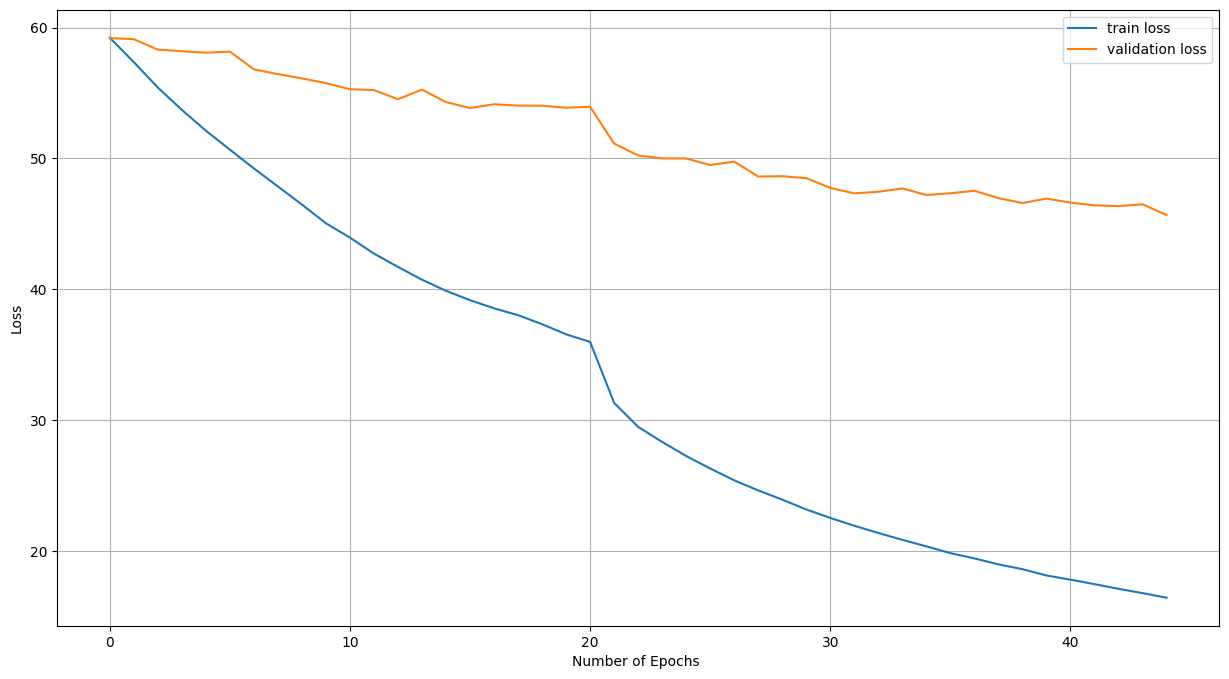

In [270]:
# Train Loss
train_loss = list(history_1.history['loss'])
train_loss.extend(history_2.history['loss'])
#train_loss.extend(history_3.history['loss'])
#train_loss.extend(history_4.history['loss'])

# Validation Loss
val_loss = list(history_1.history['val_loss'])
val_loss.extend(history_2.history['val_loss'])
#val_loss.extend(history_3.history['val_loss'])
#val_loss.extend(history_4.history['val_loss'])

# plot history
plt.plot(np.array(train_loss[5:]), label='train loss')
plt.plot(np.array(val_loss[5:]), label='validation loss')
plt.xlabel("Number of Epochs ")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

## Prediction - from Transformer

In [271]:
predictions = transformer((X_test_f), training=False)

In [272]:
predictions.shape

TensorShape([6720, 1])

In [273]:
predictions[0]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.30306453], dtype=float32)>

In [274]:
i = 12
print('Predictions = \n',predictions[i])
print('Actuals = \n',y_test[i])

Predictions = 
 tf.Tensor([-2.0105665], shape=(1,), dtype=float32)
Actuals = 
 -0.3000000000000113


### Validating the results

In [275]:
y_pred = predictions.numpy().reshape(-1)
y_test = y_test.reshape(-1)
print(y_pred.shape)
print(y_test.shape)

(6720,)
(6720,)


In [276]:
score_mae = mean_absolute_error(y_test, y_pred)
print("The Mean Absolute Error of our Model is {}".format(round(score_mae, 2)))
score_rmse = mean_squared_error(y_test, y_pred)
print("The Root Mean Squared Error of our Model is {}".format(round(score_rmse, 2)))
score_r2 = r2_score(y_test, y_pred)
print("The accuracy of our model is {}%".format(round(score_r2, 2) *100))

The Mean Absolute Error of our Model is 4.31
The Root Mean Squared Error of our Model is 47.05
The accuracy of our model is 28.999999999999996%


In [277]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,10000,1),
                    open=y_pred,
                    high=y_pred,
                    low=y_test,
                    close=y_test
                              )])
fig.show()

In [ ]:
'''
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=y_pred,
                    high=y_pred,
                    low=y_test,
                    close=y_test
                              )])
fig.show()
'''

'\nfig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),\n                    open=y_pred,\n                    high=y_pred,\n                    low=y_test,\n                    close=y_test\n                              )])\nfig.show()\n'

 ## Prediction - from Saved model

In [ ]:
# Save the model - not required - using different save method

#model_path = '/content/drive/MyDrive/hobby_project/Models/forecaster_future1_pred_finetune/'
#tf.saved_model.save(osf_tf_function, export_dir=model_path)

In [ ]:
# Load the model
model_path = '/content/drive/MyDrive/hobby_project/Models/1SF_nsepy_Model_inp512_out1_fourierTransform/'
pre_trained_forecaster = tf.saved_model.load(model_path)

In [ ]:
print(checkpoint_filepath)

/content/drive/MyDrive/hobby_project/Models/1SF_nsepy_Model_inp39_out1_vocab90.weights.weights.h5


In [ ]:
transformer.load_weights(checkpoint_filepath)

### Prediction from Pre-trained loaded transformer

In [ ]:
predictions_reconstructed_model = transformer((c_test_pad[:1000],X_test_pad[:1000]), training=False)
y_test_redused = y_test_pad[:1000]

In [ ]:
predictions_val_reconstructed_model = np.argmax(predictions_reconstructed_model, axis=2)
predictions_val_reconstructed_model.shape

(1000, 41)

In [ ]:
i = 1
print('Predictions = \n',predictions_val_reconstructed_model[i])
print('Actuals = \n',y_test_redused[i])

Predictions = 
 [39 38 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39
 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39 39]
Actuals = 
 [53  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 89]


### Compare saved model with Actuals

In [ ]:
y_reconstructed_model = predictions_val_reconstructed_model[:,1]

In [ ]:
print(y_reconstructed_model.shape)
print(y_test[:1000].shape)

accuracy = accuracy_score(y_test[:1000],y_reconstructed_model)
print(f"Accuracy: {accuracy:.2f}")

(1000,)
(1000, 1)
Accuracy: 0.02


In [ ]:
fig = go.Figure(data=[go.Ohlc(x=np.arange(0,1000,1),
                    open=y_reconstructed_model,
                    high=y_reconstructed_model,
                    low=y_test[:1000].reshape(-1),
                    close=y_test[:1000].reshape(-1)
                              )])
fig.show()

### Exporting the outputs to csv

In [ ]:
data_df = pd.read_csv(path+'/OSF_results.csv')
data_df.columns

Index(['Actuals', 'OSF_Model_1', 'OSF_2'], dtype='object')

In [ ]:
# Uncomment only if you wish to compare the data in excel sheet
data_df = pd.read_csv(path+'/OSF_results.csv')
#data_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

# Using DataFrame.insert() to add a column
#data_df.insert(2, "OSF_2", y_reconstructed_model, True)
data_df.insert(2, "OSF_2_better", y_pred, True)

data_df

,Actuals,OSF_Model_1,OSF_2_better,OSF_2
0,542,542,542,542
1,509,509,509,509
2,722,562,586,588
3,517,517,517,517
4,525,525,525,525
...,...,...,...,...
2518,520,520,520,520
2519,500,500,500,500
2520,542,542,542,542
2521,523,523,523,523


In [ ]:
data_df.to_csv(path+'/OSF_results.csv',index=False)

# Failed Models

# Success Models

In [ ]:
# 1st Best model
# Input formation
'''
data_q1 = data_df.iloc[:1200,:129].copy()
data_q2 = data_df.iloc[:1200,128:257].copy()
data_q3 = data_df.iloc[:1200,256:385].copy()
data_q4 = data_df.iloc[:1200,384:].copy()
data_df_merged = pd.DataFrame()
data_df_merged = pd.concat([pd.DataFrame(data_q1.values),pd.DataFrame(data_q2.values),pd.DataFrame(data_q3.values),pd.DataFrame(data_q4.values)],
                           ignore_index=True)
'''
# Inputs
'''
X Train shape (3240, 128)
Context Train shape (3240, 1)
Y Train shape (3240, 1)
X Validation shape (1080, 128)
Context Validation shape (1080, 1)
Y Validation shape (1080, 1)
X Test shape (480, 128)
Context Test shape (480, 1)
Y Test shape (480, 1)
'''
# Hyperparameters
'''
# Hyperparameters for Fourier Transform
signal_len = X_train.shape[1] # Length of the input time series
frame_length = 128 # window size for Fourier Transform
frame_step = 64 # Hop size for Fourier Transform
fft_length = frame_length

# Hyperparameters for Attention Layer and DNN Layer
num_layers = 2 # number of TransformerEncoderLayer layers (Original paper = 6)
num_heads = 1 # number of self-attention heads in the MultiheadAttention layer (Original paper = 8)
dropout_rate = 0.2 # Dropout rate

Time Bins = 1
Frequency Bins = 65
output_shape=[batch_size, time_bins, frequency_bins]
Output shape = (batch_size, 1 , 65 )
'''
# Weights
'''
Model: "transformer"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ fourier_transform (FourierTransform) │ ?                           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Encoder)                    │ ?                           │          69,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │         103,870 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (3, 65)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (3, 1)                      │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘
 Total params: 173,224 (676.66 KB)
 Trainable params: 173,096 (676.16 KB)
 Non-trainable params: 128 (512.00 B)
'''

# Output
'''
Test
The Mean Absolute Error of our Model is 1.47
The Root Mean Squared Error of our Model is 20.26
The accuracy of our model is 32.0%